# Mass Spectra for Cancer Prediction_Data Wrangling

###### Peter Liu 6/11/2018

Data are downloaded from https://home.ccr.cancer.gov/ncifdaproteomics/ppatterns.asp

Here I adopted Ovarian Dataset 8-7-02. This is a set of mass spectra of ovarian serum from patients and healthy people. Samples were prepared by robotic sample handling (washing, incubation, etc) using WCX2 protein chip and the spectra were generated by PBSII SELDI-TOF mass spectrometer. The sample set included 91 controls and 162 ovarian cancers.

## 1. Data Import, Cleaning and Transformation (Trial with single file)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
% matplotlib inline

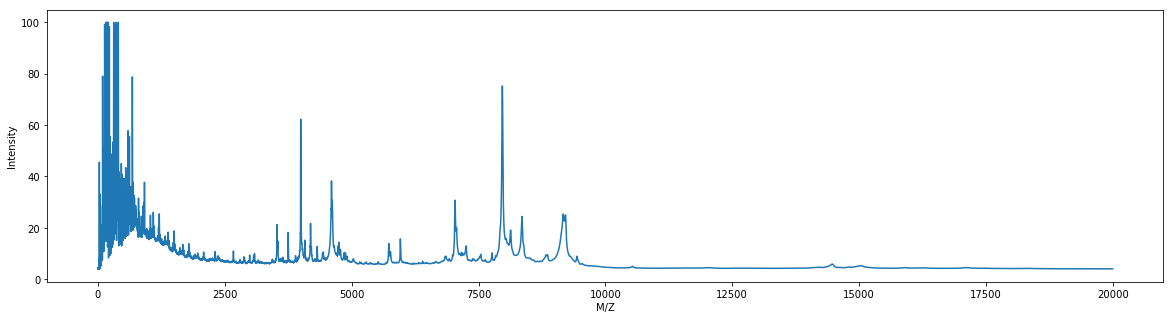

In [2]:
# Read cancer spectrum into pd dataframe
df = pd.read_csv('Database used\OvarianDataset_Robotic Handled\Cancer\Ovarian Cancer daf-0601.csv')

# Plot the Mass Spectrum
plt.figure(figsize=[20,5])
plt.plot(df['M/Z'], df['Intensity'])
plt.xlabel('M/Z')
plt.ylabel('Intensity')

#### Step 1. The mass less than 200 (matrix interference) and mass over 10000 provide weak or no influence on results, so I removed points in the above region

In [3]:
# Select regions where 200 < M/Z < 10000
df = df[(df['M/Z']>200) & (df['M/Z']<10000)]
df.head()

,M/Z,Intensity
1517,200.17821,100.000000
1518,200.44238,100.000000
1519,200.70672,100.000000
1520,200.97123,99.929613
1521,201.23592,99.702363


#### Step 2. Baseline substraction: Subtracted in a window the median of the 20% smallest values

In [4]:
# Compute the median value of the 20% smallest values
median = np.median(np.sort(df.Intensity)[:(len(df.Intensity)//5)])
print('The median intensity of the 20% smallest intensity is: {}'.format(median))

# Construct new data frame using updated Intensity
df.Intensity = df.Intensity.apply(lambda x: x-median if (x-median)>=0 else 0)

df.head()

The median intensity of the 20% smallest intensity is: 6.1987597


,M/Z,Intensity
1517,200.17821,93.801240
1518,200.44238,93.801240
1519,200.70672,93.801240
1520,200.97123,93.730853
1521,201.23592,93.503603


#### Step 3. Re-scaling and taking the square root: The spectra were divided by the median of the 5% top values, and the square root of the all values was taken.

In [6]:
# Compute the median value of the top 5% intensity values
top_median = np.median(np.sort(df.Intensity)[::-1][:(int(len(df.Intensity)*0.05))])
print('The median intensity of the top 5% intensity is: {}'.format(top_median))

# Construct new data frame using updated Intensity
df.Intensity = df.Intensity.apply(lambda x: x/top_median)
df.Intensity = np.sqrt(df.Intensity)

df.head()

The median intensity of the top 5% intensity is: 31.6866098


,M/Z,Intensity
1517,200.17821,1.720546
1518,200.44238,1.720546
1519,200.70672,1.720546
1520,200.97123,1.719901
1521,201.23592,1.717815


#### Step 4. Some initiative plotting and imaging the sepctrum data
The more yellow the region is, the higher intensity of the M/Z. Notice that there are several regions of dark blue indicating that the intensity is essentially 0.

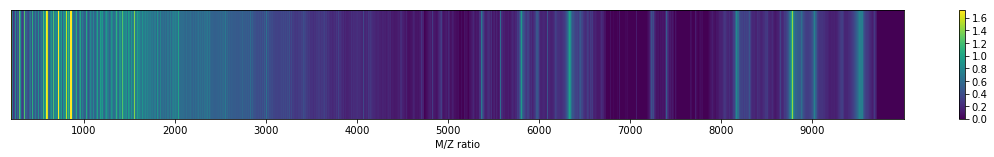

In [7]:
# Plot the heatmap of M/Z ratio of mass spectrum
plt.figure(figsize=[20,2])
plt.imshow(df.Intensity[np.newaxis,:], aspect="auto", extent=[200,10000,0,1])
plt.yticks([])
plt.xticks(np.arange(1000, 10000, 1000))
plt.colorbar()
plt.xlabel('M/Z ratio')

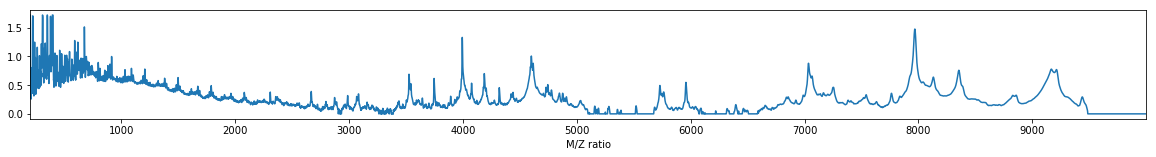

In [8]:
# Plot modified mass spectrum
plt.figure(figsize=[20,2])
plt.plot(df['M/Z'], df.Intensity)
plt.xlabel('M/Z ratio')
plt.xlim(200, 10000)
_ = plt.xticks(np.arange(1000, 10000, 1000))

#### Step 5. Transform the dataframe to a 'wider' form

In [9]:
# Pivot the dataframe, making the dataframe a 'wider' form
df_transform= df.pivot_table(columns='M/Z')
df_transform = df_transform.reset_index().iloc[:,1:]

In [10]:
# A wide format of M/Z ratio
df_transform

M/Z,200.17821,200.44238,200.70672,200.97123,201.23592,201.50078,201.76582,202.03103,202.29642,202.56198,...,9982.7063,9984.5713,9986.4364,9988.3017,9990.1672,9992.0328,9993.8987,9995.7647,9997.6308,9999.4972
0,1.720546,1.720546,1.720546,1.719901,1.717815,1.713023,1.692505,1.672132,1.63622,1.560843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Data Import, Cleaning, Transformation and Concat (Mutiple files)

#### Step 1. Define methods to transform single spectrum file and combine multiple spectrum files

In [11]:
# Define methods to transform single csv file to wider form
def data_transform(path):
    # Read csv file
    df = pd.read_csv(path)
    df.columns = ['M/Z', 'Intensity']
    
    # Select mass window between 200 and 10000
    df = df[(df['M/Z']>200) & (df['M/Z']<10000)]
    
    # Baseline substration. Substract the spectra with the median of lowest 20% intensity
    median = np.median(np.sort(df.Intensity)[:(len(df.Intensity)//5)])
    df.Intensity = df.Intensity.apply(lambda x: x-median if (x-median)>=0 else 0)
    
    # Rescale by dividing the intensity with the median of top 5% intensity and take the rootsqure
    top_median = np.median(np.sort(df.Intensity)[::-1][:(int(len(df.Intensity)*0.05))])
    df.Intensity = df.Intensity.apply(lambda x: x/top_median)
    df.Intensity = np.sqrt(df.Intensity)
    
    # Pivot table and return the resulting data frame
    df_transform= df.pivot_table(columns='M/Z')
    df_transform = df_transform.reset_index().iloc[:,1:]
    
    return df_transform

In [12]:
# Define methods to transform and concat all dataframe to one single dataframe
def transform_combine_spectra(folder):    
    csv_list = glob.glob('Database used\\'+ folder + '\\*.csv')
    df = pd.DataFrame()
    for csv_file in csv_list:
        temp = data_transform(csv_file)
        df_update = pd.concat((df, temp), ignore_index=True)
        if np.any(df.isnull()):
            print('There is mismatch of data points!')
            break
        else:
            df = df_update
    return df

#### Step 2. Create ovarian data and labels

In [13]:
# Spectra data for cancer group
cancer_group = transform_combine_spectra('OvarianDataset_Robotic Handled\Cancer')

In [14]:
# Spectra data for non cancer group
control_group = transform_combine_spectra('OvarianDataset_Robotic Handled\Control')

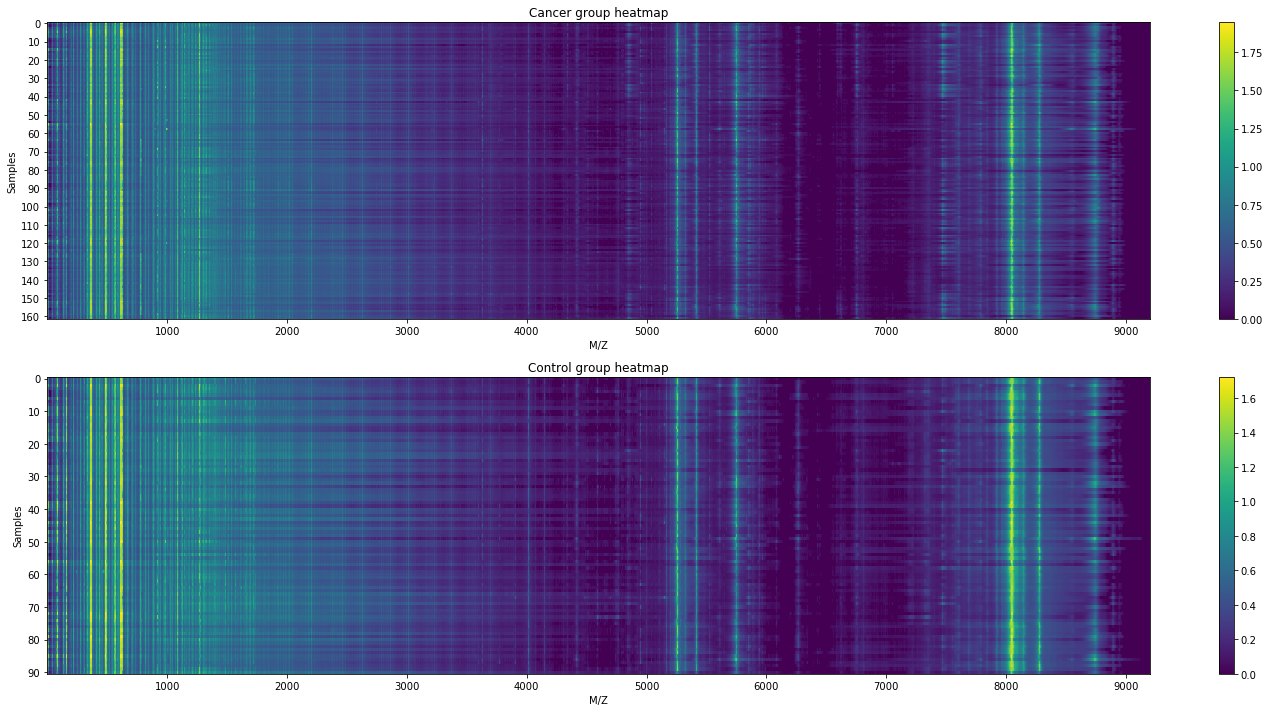

In [15]:
# Compare the mass spectra of cancer group and non-cancer group

plt.figure(figsize=[20,10])

# Cancer group spectra
plt.subplot(211)
plt.title('Cancer group heatmap')

plt.imshow(cancer_group, aspect='auto')
plt.xticks(np.arange(1000, 10000, 1000))
plt.yticks(np.arange(0,161, 10))
plt.xlabel('M/Z')
plt.ylabel('Samples')
plt.colorbar()

# Non-cancer group spectra
plt.subplot(2,1,2)
plt.title('Control group heatmap')
plt.imshow(control_group, aspect='auto')
plt.xticks(np.arange(1000, 10000, 1000))
plt.yticks(np.arange(0,91,10))
plt.xlabel('M/Z')

plt.ylabel('Samples')
plt.colorbar()

plt.tight_layout()

In [16]:
# Combine labels and generate y
y = np.concatenate((np.repeat(1, cancer_group.shape[0]), np.repeat(-1, control_group.shape[0])))

In [17]:
# Create ovarian data and labels by concating cancer and control groups
ovarian_data = pd.concat((cancer_group, control_group), ignore_index=True)
ovarian_label = y

In [18]:
# Save ovarian_data to csv file
ovarian_data.to_csv('ovarian_data.csv')

In [19]:
# Save labels to txt file
np.savetxt('ovarian_label.txt', ovarian_label)